Track analysis
============

Analysis of track data only i.e. no linking to pixel-level data or ERA5. Basic histograms of quantities, growth/decay calculations, stratification of data ideas and lifetime plotting.

* 18/5/22: initial work, building off ideas I had played around with in `ipython`.

In [1]:
import datetime as dt
import itertools
from pathlib import Path

import dask
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
from scipy import interpolate
import xarray as xr

from mcs_prime import McsTracks, PATHS
from mcs_prime.util import update_progress
%matplotlib inline

/home/users/mmuetz/miniconda3/envs/mcs_prime_env/lib/python3.10/site-packages/pyproj/__init__.py:89: UserWarning: pyproj unable to set database path.
  _pyproj_global_context_initialize()


Load all tracks from 2000/6-2020/12

In [2]:
tracks = tracks = McsTracks.mfload(str(PATHS['statsdir'] / 'mcs_tracks_final_extc_*.0000.nc'), 
                                   PATHS['pixeldir'], 
                                   False)
ntracks = len(tracks.dstracks.tracks)
tracks

McsTracks[2000-06-01 00:30:00.000013440, 2020-12-31 22:30:00, ntracks=696293]

`McsTracks` provides a wrapper around a `dstracks` object, which is an `xarray.DataSet`.

In [3]:
tracks.dstracks
# How does dstracks look so good? It implements _repr_html_() which returns all the HTML you can see below.
# Looks like a lot of work for this, but a simplified version could be nice for other objects.

<xarray.Dataset>
Dimensions:                  (tracks: 696293, times: 400, mergers: 50, nmaxpf: 3)
Coordinates:
  * tracks                   (tracks) int64 0 1 2 3 ... 696290 696291 696292
  * times                    (times) int64 0 1 2 3 4 5 ... 395 396 397 398 399
  * mergers                  (mergers) int64 0 1 2 3 4 5 6 ... 44 45 46 47 48 49
  * nmaxpf                   (nmaxpf) int64 0 1 2
Data variables: (12/55)
    track_duration           (tracks) int32 dask.array<chunksize=(21142,), meta=np.ndarray>
    start_status             (tracks) int32 dask.array<chunksize=(21142,), meta=np.ndarray>
    end_status               (tracks) int32 dask.array<chunksize=(21142,), meta=np.ndarray>
    start_basetime           (tracks) datetime64[ns] dask.array<chunksize=(21142,), meta=np.ndarray>
    end_basetime             (tracks) datetime64[ns] dask.array<chunksize=(21142,), meta=np.ndarray>
    start_split_cloudnumber  (tracks) int32 dask.array<chunksize=(21142,), meta=np.ndarray>
    ...                       ...
    pf_mcsstatus             (tracks, times) int64 dask.array<chunksize=(21142, 400), meta=np.ndarray>
    movement_distance        (tracks, times) float32 dask.array<chunksize=(21142, 400), meta=np.ndarray>
    movement_speed           (tracks, times) float32 dask.array<chunksize=(21142, 400), meta=np.ndarray>
    movement_theta           (tracks, times) float32 dask.array<chunksize=(21142, 400), meta=np.ndarray>
    movement_distance_x      (tracks, times) float32 dask.array<chunksize=(21142, 400), meta=np.ndarray>
    movement_distance_y      (tracks, times) float32 dask.array<chunksize=(21142, 400), meta=np.ndarray>
Attributes: (12/23)
    Title:                       Statistics of each MCS track
    Institution:                 Pacific Northwest National Laboratory
    Contact:                     Zhe Feng, zhe.feng@pnnl.gov
    Created_on:                  Wed Mar  9 18:38:34 2022
    startdate:                   20000601.0000
    enddate:                     20010101.0000
    ...                          ...
    PF_PF_min_majoraxis_thresh:  20
    coefs_pf_area:               [2874.05    89.825]
    coefs_pf_rr:                 [3.01657   0.0144461]
    coefs_pf_skew:               [0.194462  0.0100072]
    coefs_pf_heavyratio:         [3.419024 0.438709]
    max_speed_thresh:            50

In [4]:
nanmask = ~np.isnan(tracks.dstracks.meanlon.values)
print(nanmask.sum())
print(tracks.dstracks.track_duration.values.sum()) 
# Why are these off by one?

12648956
12648957


Histograms
--------------

In [5]:
np.percentile(tracks.dstracks.track_duration.values, [33.3, 66.6])

array([12., 20.])

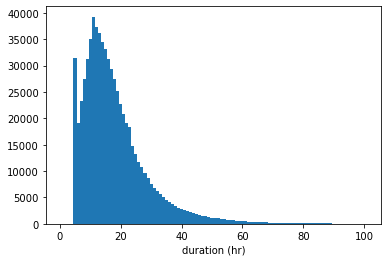

In [6]:
plt.hist(tracks.dstracks.track_duration.values, bins=np.linspace(0, 100, 101) + 0.5)
plt.xlabel('duration (hr)');
# Why is there a spike at n=4?

Almost all MCS have lifetime < 100 hr; there is a minimum lifetime of 4 hr (visual inspection). Interesting distribution -- lognormal or Poisson?

502 696293 696293


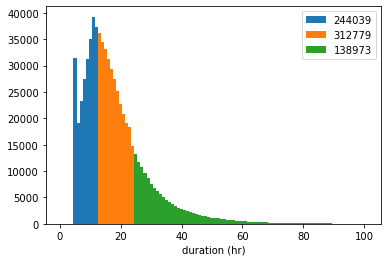

In [7]:
# Use 12, 24 as natural thresholds to split durations into roughly 3:
(n12, n12_24, n24_100, n100), _ = np.histogram(tracks.dstracks.track_duration.values, 
                                               bins=[0.5, 12.5, 24.5, 100.5, 1000])
plt.hist(tracks.dstracks.track_duration.values, bins=np.linspace(0, 12, 13) + 0.5, label=n12)
plt.hist(tracks.dstracks.track_duration.values, bins=np.linspace(12, 24, 13) + 0.5, label=n12_24)
plt.hist(tracks.dstracks.track_duration.values, bins=np.linspace(24, 100, 77) + 0.5, label=n24_100)
plt.legend()
plt.xlabel('duration (hr)')
# Sanity check on ntracks.
print(n100, n12 + n12_24 + n24_100 + n100, ntracks)

In [8]:
max_areas = np.nanmax(tracks.dstracks.area.values, axis=1)
mean_areas = np.nanmean(tracks.dstracks.area.values, axis=1)
max_area_thresh = np.percentile(max_areas, [25, 50, 75])
mean_area_thresh = np.percentile(mean_areas, [25, 50, 75])
print(max_area_thresh)
print(mean_area_thresh)

[ 94900. 150100. 271000.]
[ 48684.2109375  74725.        132014.28125  ]


696293 696293


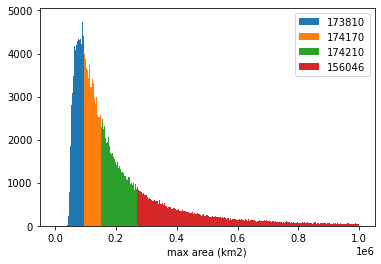

696293 696293


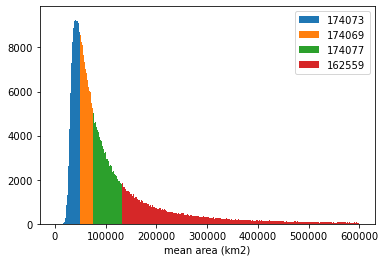

In [9]:
def area_hist(areas, bins, mode):
    bin_nums, _ = np.histogram(areas, bins)
    for i in range(len(bins) - 2):
        dbin = bins[i + 1] - bins[i]
        plt.hist(areas, bins=np.linspace(bins[i], bins[i + 1], int(dbin / 1000)), label=bin_nums[i])
    plt.legend()
    plt.xlabel(f'{mode} area (km2)')
    # Sanity check on ntracks.
    print(sum(bin_nums), ntracks)
    
bins = [0] + list(max_area_thresh) + [1e6, 1e7]
area_hist(max_areas, bins, 'max')
plt.show()

bins = [0] + list(mean_area_thresh) + [0.6e6, 1e7]
area_hist(mean_areas, bins, 'mean')

These two seem to look very similar - and they are strongly correlated (see below). Again, what distribution?

LinregressResult(slope=0.46786757035956805, intercept=6983.960350932466, rvalue=0.9379662039347543, pvalue=0.0, stderr=0.0002072657970745685, intercept_stderr=75.65187818266732)
0.8797805997237731


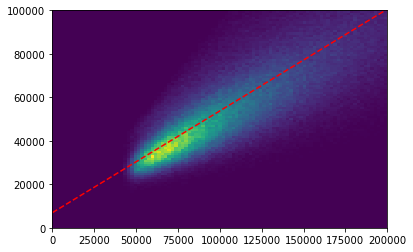

In [10]:
plt.hist2d(max_areas, mean_areas, bins=(np.linspace(0, 2e5, 100), np.linspace(0, 1e5, 100)))
reg = stats.linregress(max_areas, mean_areas)
x = np.array([0, 2e5])
plt.plot(x, reg.intercept + reg.slope * x, 'r--')
print(reg)
print(reg.rvalue**2)

9.972


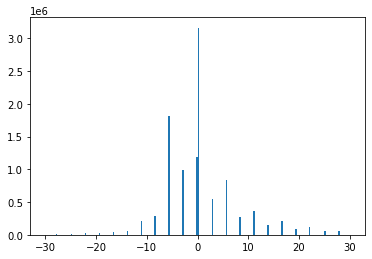

In [11]:
# N.B. movement_dist_x is in km/hr - convert to m/s by dividing by 3.6
plt.hist(tracks.dstracks.movement_distance_x.values[nanmask] / 3.6, bins=np.arange(-30, 30.25, 0.25))
print(2.77 * 3.6)

Clear that data are distributed discontinuously - roughly every 2.77 m/s. Or every 10 km (this is probably the mean gridlength at 0.1deg resolution)

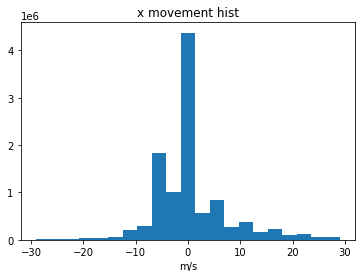

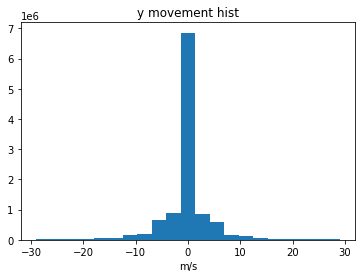

In [12]:
dbin = 2.77
bins = np.arange(-10 * dbin - dbin / 2, 11 * dbin + dbin / 2, dbin)
xvals, _, _ = plt.hist(tracks.dstracks.movement_distance_x.values[nanmask] / 3.6, bins=bins)
plt.title('x movement hist')
plt.xlabel('m/s')
plt.show()

yvals, _, _ = plt.hist(tracks.dstracks.movement_distance_y.values[nanmask] / 3.6, bins=bins)
plt.title('y movement hist')
plt.xlabel('m/s');

In [13]:
speed = np.sqrt((tracks.dstracks.movement_distance_x.values[nanmask] / 3.6)**2 + (tracks.dstracks.movement_distance_y.values[nanmask] / 3.6)**2)

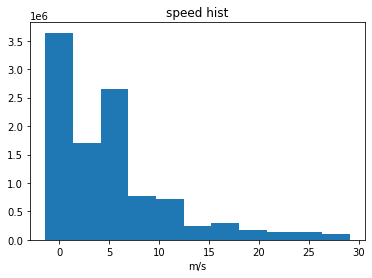

In [14]:
speedvals, _, _ = plt.hist(speed, bins=bins[10:])
plt.title('speed hist')
plt.xlabel('m/s');

In [15]:
print(f'x - {xvals[10] / xvals.sum() * 100:.1f}%')
print(f'y - {yvals[10] / yvals.sum() * 100:.1f}%')
print(f'speed - {speedvals[0] / speedvals.sum() * 100:.1f}%')


x - 41.0%
y - 63.5%
speed - 34.5%


There seems to be an aliasing effect or similar for x - every 2nd value for +ve x is larger. 

**Zero speed accounts for approx. 1/3 of all values in both cases.** This is interesting - it suggests that we can ignore MCS propagation as a first approximation.

## Area/precip area growth

Work out at each MCS point whether areas are growing or shrinking. This could be used to stratify the data, and/or env conditions.


In [16]:
area_growth = tracks.dstracks.area[:, 1:].values - tracks.dstracks.area[:, :-1].values
total_rain_growth = tracks.dstracks.total_rain[:, 1:].values - tracks.dstracks.total_rain[:, :-1].values

growth_nanmask = ~np.isnan(area_growth)

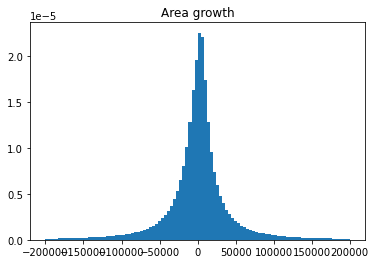

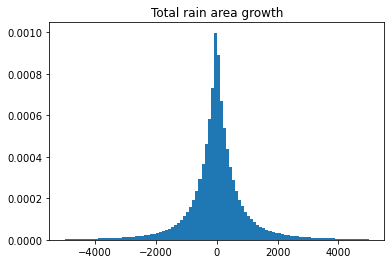

In [17]:
bins = np.linspace(-2e5, 2e5, 101)
plt.hist(area_growth[growth_nanmask], bins=bins, density=True)
plt.title('Area growth')
plt.show()

bins = np.linspace(-5000, 5000, 101)
plt.hist(total_rain_growth[growth_nanmask], bins=bins, density=True);
plt.title('Total rain area growth');

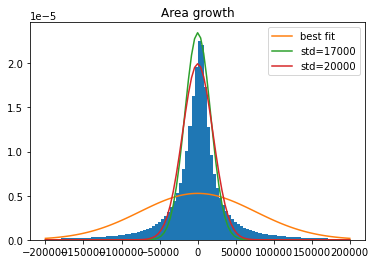

In [18]:
# Wonder how these are distributed? A normal distribution does not fit:
from scipy.stats import norm 
mean, std = norm.fit(area_growth[growth_nanmask]) 
bins = np.linspace(-2e5, 2e5, 101)
plt.hist(area_growth[growth_nanmask], bins=bins, density=True)
plt.plot(bins, norm.pdf(bins, mean, std), label='best fit')
plt.plot(bins, norm.pdf(bins, mean, 17000), label='std=17000')
plt.plot(bins, norm.pdf(bins, mean, 20000), label='std=20000')
plt.legend()
plt.title('Area growth');

These are sharply peaked with heavy tails. I am not sure what distribution might fit these.

## Lifetime plots

Stratify the lifetimes into <12, 12-24, >24 hr. Produce lifetime plots of various variables for these.

I will need to do 1D interpoloation onto a standardized lifetime (e.g. 0-1 in steps of 0.2 or similar), so that I can compare different tracks.

In [19]:
results_cache = Path('.results_cache')  # Allows quick replotting.
results_cache.mkdir(exist_ok=True)

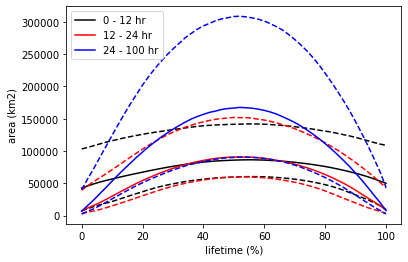

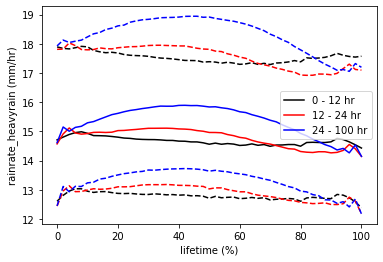

In [20]:
def gen_lifetimes(subtracks, variable):
    subtracks.dstracks.track_duration.load()
    subtracks.dstracks[variable].load()
    area_lifetimes = []
    ntracks = len(subtracks.dstracks.tracks)
    for track_id in range(ntracks):
        if track_id % 10000 == 0:
            update_progress((track_id + 1) / ntracks)
            
        duration = subtracks.dstracks.track_duration.values[track_id]
        fn = interpolate.interp1d(np.arange(duration), subtracks.dstracks[variable].values[track_id, :duration])
        area_lifetimes.append(fn(np.linspace(0, duration - 1, 51)))
    update_progress(1)
    area_lifetimes = np.array(area_lifetimes)
    p25, p50, p75 = np.nanpercentile(area_lifetimes, [25, 50, 75], axis=0)
    return p25, p50, p75


def plot_lifetimes(p25, p50, p75, variable, units, mindur, maxdur, colour):
    label = f'{mindur} - {maxdur} hr'
    plt.plot(np.linspace(0, 100, 51), p50, linestyle='-', color=colour, label=label)
    plt.plot(np.linspace(0, 100, 51), p25, linestyle='--', color=colour)
    plt.plot(np.linspace(0, 100, 51), p75, linestyle='--', color=colour)
    plt.legend()
    plt.xlabel('lifetime (%)')
    plt.ylabel(f'{variable} ({units})')


# for variable, units in [('rainrate_heavyrain', 'mm/hr')]:
for variable, units in [('area', 'km2'), ('rainrate_heavyrain', 'mm/hr')]:
    plt.figure()
    for mindur, maxdur, colour in [(0, 12, 'k'), (12, 24, 'r'), (24, 100, 'b')]:
        cache_path = results_cache / f'{variable}_{mindur}_{maxdur}.nc'
        if cache_path.exists():
            ds = xr.open_dataset(cache_path)
            p25, p50, p75 = ds.p25, ds.p50, ds.p75
        else:
            mask = (tracks.dstracks.track_duration > mindur) & (tracks.dstracks.track_duration <= maxdur)
            with dask.config.set(**{'array.slicing.split_large_chunks': False}):
                subtracks = McsTracks(tracks.dstracks.isel(tracks=mask), tracks.pixel_data)
            p25, p50, p75 = gen_lifetimes(subtracks, variable)
            ds = xr.Dataset(
                data_vars=dict(p25=('lifetime', p25), p50=('lifetime', p50), p75=('lifetime', p75)),
                coords=dict(lifetime=np.linspace(0, 1, len(p25)))
            )
            ds.to_netcdf(cache_path)
        plot_lifetimes(p25, p50, p75, variable, units, mindur, maxdur, colour)
            
        # plt.title(f'Tracks with lifetime {mindur} - {maxdur} hr')
    plt.plot()

Area looks roughly as I expected. There are a couple of interesting points though. 0-12 hr starts much higher than either 12-24 or >24. Both <24 have similar median/25/75 values at 50%. >24 clearly much greater area at max lifetime. Lifetimes all approx. symmetrical.

heavy rainrate is more interesting. Note, there is a threshold on >10mm/hr. 0-12 is approx. flat over its lifetime, and 12-24, >24 show a minor arc (stronger for >24). Note, this would be x by area to give total rain, which means that the total rain would have a much greater arc (check this). 

## Correlations between various fields (averaged over the lifetime of each MCS)

In [21]:
status = tracks.dstracks.track_status.values

In [22]:
pf_area_mean = tracks.dstracks.pf_area.mean(dim='nmaxpf').where(status >= 1).mean(dim='times').values

In [23]:
duration = tracks.dstracks.track_duration.values

In [24]:
pf_area_mean.shape, duration.shape

((696293,), (696293,))

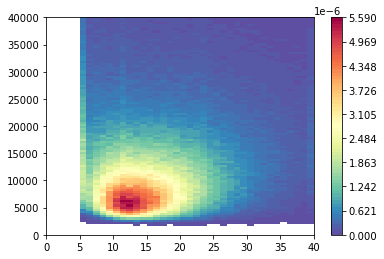

In [25]:
hist, xedges, yedges = np.histogram2d(pf_area_mean, duration, bins=(np.linspace(0, 40000, 101), np.linspace(0, 40, 41)), density=True)
xmid = (xedges[:-1] + xedges[1:]) / 2
ymid = (yedges[:-1] + yedges[1:]) / 2
hist[hist == 0] = np.nan
cmap = 'Spectral_r'
lev1 = np.array(np.linspace(0, 1, 64)) * np.nanmax(hist)
norm = mpl.colors.BoundaryNorm(boundaries=lev1, ncolors=256)
                                                                 
pcm = plt.pcolormesh(ymid, xmid, hist, cmap=cmap, norm=norm)
plt.colorbar(pcm);

In [26]:
variables = ['pf_area', 'pf_rainrate', 'area', 'pf_maxrainrate', 'total_rain', 'total_heavyrain']
units = {
    'pf_area': 'km$^2$',
    'pf_rainrate': 'mm hr$^{-1}$',
    'area': 'km$^2$',
    'pf_maxrainrate': 'mm hr$^{-1}$',
    'total_rain': 'mm hr$^{-1}$',
    'total_heavyrain': 'mm hr$^{-1}$',
}

pf_area
pf_rainrate
area
pf_maxrainrate
total_rain
total_heavyrain


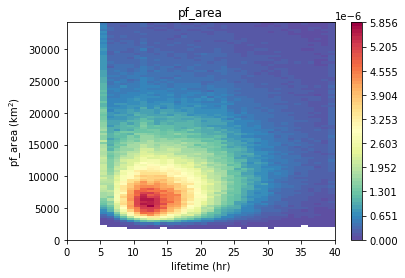

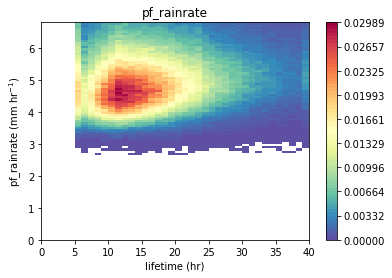

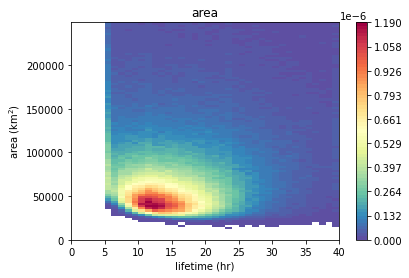

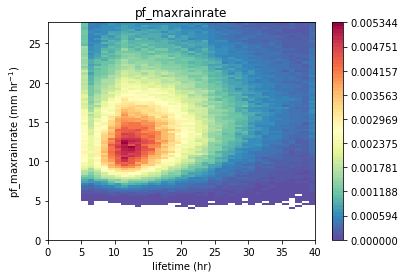

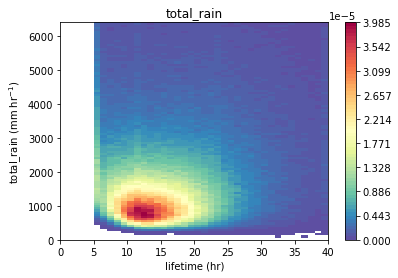

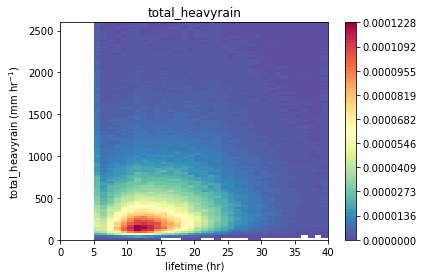

In [27]:
def plot_mean_data(ax, var, mean_data, duration):
    upper_limit = np.nanpercentile(mean_data, 90)
    hist, xedges, yedges = np.histogram2d(mean_data, duration, bins=(np.linspace(0, upper_limit, 101), np.linspace(0, 40, 41)), density=True)
    xmid = (xedges[:-1] + xedges[1:]) / 2
    ymid = (yedges[:-1] + yedges[1:]) / 2
    hist[hist == 0] = np.nan
    cmap = 'Spectral_r'
    lev1 = np.array(np.linspace(0, 1, 64)) * np.nanmax(hist)
    norm = mpl.colors.BoundaryNorm(boundaries=lev1, ncolors=256)

    pcm = ax.pcolormesh(ymid, xmid, hist, cmap=cmap, norm=norm)
    plt.colorbar(pcm, ax=ax)
    
    ax.set_title(var)
    ax.set_xlabel('lifetime (hr)')
    ax.set_ylabel(f'{var} ({units[var]})')

means = {}
for var in variables:
    print(var)
    cache_path = results_cache / f'{var}.nc'
    if cache_path.exists():
        mean_data = xr.open_dataarray(cache_path)
    else:
        if var[:2] == 'pf':
            data = tracks.dstracks[var].mean(dim='nmaxpf')
        else:
            data = tracks.dstracks[var]
        mean_data = data.where(status >= 1).mean(dim='times')
        mean_data.to_netcdf(cache_path)
    means[var] = mean_data.values

for var in variables:
    fig, ax = plt.subplots()
    plot_mean_data(ax, var, means[var], duration)
    plt.show()

## Correlations between various fields (based on MCS track points)

In [ ]:
def plot_track_point_data(ax, var1, var2, data1, data2):
    nanmask = ~np.isnan(data1)
    upper_limit1 = np.nanpercentile(data1, 90)
    upper_limit2 = np.nanpercentile(data2, 90)
    hist, xedges, yedges = np.histogram2d(data1[nanmask], data2[nanmask], bins=(np.linspace(0, upper_limit1, 101), np.linspace(0, upper_limit2, 101)), density=True)
    xmid = (xedges[:-1] + xedges[1:]) / 2
    ymid = (yedges[:-1] + yedges[1:]) / 2
    hist[hist == 0] = np.nan
    cmap = 'Spectral_r'
    lev1 = np.array(np.linspace(0, 1, 64)) * np.nanmax(hist)
    norm = mpl.colors.BoundaryNorm(boundaries=lev1, ncolors=256)

    pcm = ax.pcolormesh(ymid, xmid, hist, cmap=cmap, norm=norm)
    plt.colorbar(pcm, ax=ax)
    
    reg = stats.linregress(data2, data1)
    plt.plot(ymid, ymid * reg.slope + reg.intercept)
    
    ax.set_xlabel(f'{var2} ({units[var2]})')
    ax.set_ylabel(f'{var1} ({units[var1]})')


all_data = {}
for var in variables[:2]:
    print(var)
    cache_path = results_cache / f'{var}_point_values.nc'
    if cache_path.exists():
        data = xr.open_dataarray(cache_path)
    else:
        if var[:2] == 'pf':
            data = tracks.dstracks[var].mean(dim='nmaxpf')
        else:
            data = tracks.dstracks[var]
        data = data.where(status >= 1) 
        data.to_netcdf(cache_path)
    all_data[var] = data.isel(tracks=slice(0, 100000)).values


for var1, var2 in list(itertools.combinations(variables[:2], 2))[:2]:
    fig, ax = plt.subplots()
    plot_track_point_data(ax, var1, var2, all_data[var1], all_data[var2])
    plt.show()

pf_area
pf_rainrate
